In [1]:
import numpy as np
from scipy.integrate import odeint
import math
import dubins
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(42)

I apologize for the mess, I will do a better job to clean this up next time, putting some of the functions and methods into separate scripts. As mentioned, there is no issue with the noise addition, it is just that the noise makes it particularly bad. I will run the kalman filter with both for the next project, to show the difference. 

In [2]:
###defining a white noise generator
def noise_sam(mean, std):
    sample = np.random.normal(mean, std, 1)
    return sample;

In [3]:
##angle conversion
def deg2rad(deg):
    return deg*np.pi/180;

In [4]:
deg2rad(3)
noise_sam(0,deg2rad(3))
list = []
for i in range(10000):
    list.append(noise_sam(0,deg2rad(3)))
    
np.max(list)

0.20557732557979339

In [5]:
class Radar:
    def __init__(self, x, y, sigma):
        self.x = x
        self.y = x
        self.sigma = sigma


In [6]:
def clear_outliers(array):
    size = array.shape
    for i in range(0,size[0]):
        for j in range(0,size[1]):
            if np.absolute(array[i,j])>26:
                array[i,j] = array[i-1,j]
                
                
    return array;

No RLR Path
No LRL Path


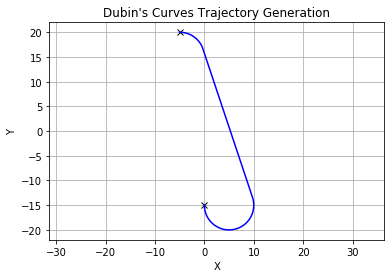

In [7]:
# User's waypoints: [x, y, heading (degrees)]
pt1 = dubins.Waypoint(0,-15,-180)
pt2 = dubins.Waypoint(-5,20,-90)
Wptz = [pt1, pt2]
# Run the code
i = 0
while i<len(Wptz)-1:
    param = dubins.calcDubinsPath(Wptz[i], Wptz[i+1], 5)
    path = dubins.dubins_traj(param,10000)
    # Plot the results
    plt.plot(Wptz[i].x,Wptz[i].y,'kx')
    plt.plot(Wptz[i+1].x,Wptz[i+1].y,'kx')
    plt.plot(path[:,0],path[:,1],'b-')
    i+=1
#print(path)
plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves Trajectory Generation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [8]:
path.shape

(10000, 3)

In [9]:
path = np.array(path)

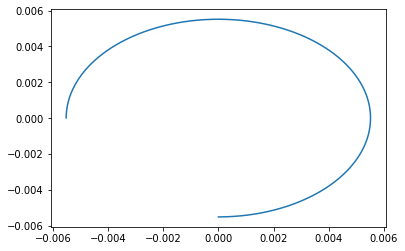

In [10]:
#use forward difference to get the velocity

vel_path = np.zeros((10000-1,3))
for i in range(0,path.shape[0]-1):
    vel_path[i,:] = path[i+1,:]-path[i,:]
    
plt.plot(vel_path[:,0], vel_path[:,1])

#corrupt the vel_path variable
for i in range(0, vel_path.shape[0]):
        noise = noise_sam(0, 0.05)
        vel_path[i,0] = vel_path[i,0]+noise*np.sin(vel_path[i,2])
        vel_path[i,1] = vel_path[i,1]+noise*np.cos(vel_path[i,2])
        vel_path[i,2] = vel_path[i,2]+noise_sam(0, 0.002)
    
#plt.scatter(vel_path[:,0], vel_path[:,1])

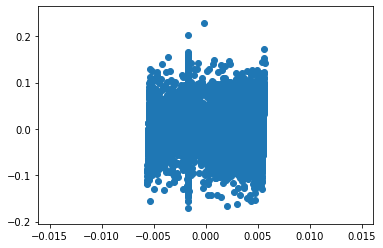

In [11]:
plt.scatter(vel_path[:,0], vel_path[:,1])

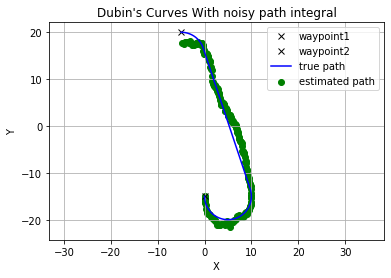

In [12]:
noise_path = np.zeros((path.shape))
noise_path[0,:] = np.array([0, -15, -90])
for i in range(0,noise_path.shape[0]-1):
    noise_path[i+1,:] = noise_path[i,:]+vel_path[i,:]
    

noise_path_intg = np.zeros((200,3))
#noise_path_intg[0,:] = np.array([0, -15, -90])
for i in range(0,200):
    noise_path_intg[i,:] = noise_path[50*i,:]

    
plt.plot(Wptz[0].x,Wptz[0].y,'kx')
plt.plot(Wptz[1].x,Wptz[1].y,'kx')
plt.plot(path[:,0],path[:,1],'b-')    
plt.scatter(noise_path_intg[:,0], noise_path_intg[:,1], color='g')
plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves With noisy path integral')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['waypoint1', 'waypoint2','true path', 'estimated path'])
plt.show()

[[-15. -10.]
 [-15.   5.]]


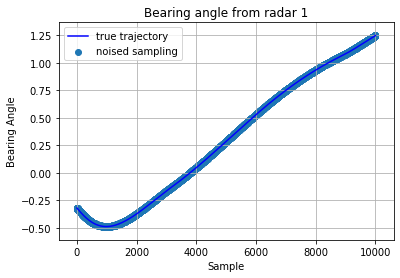

In [13]:
##generate the "true" bearing angle for the first radar set
radar_set1 = np.array([[-15, -10],[-15,5]], dtype=float)
print(radar_set1)
radar_bearing1 = np.zeros(path.shape)
radar_bearing1[:,2] = path[:,2]



for i in range(0,radar_bearing1.shape[0]):
    
    radar_bearing1[i,0] = np.arctan2((path[i,1]-radar_set1[0,1]),(path[i,0]-radar_set1[0,0]))
    radar_bearing1[i,1] = np.arctan2((path[i,1]-radar_set1[1,1]),(path[i,0]-radar_set1[1,0]))


noisy_radar_bearing1 = np.zeros(path.shape)   
for i in range(0,radar_bearing1.shape[0]):
    
    noisy_radar_bearing1[i,0] = radar_bearing1[i,0]+noise_sam(0,deg2rad(0.1))
    noisy_radar_bearing1[i,1] = radar_bearing1[i,1]+noise_sam(0,deg2rad(0.1))
    noisy_radar_bearing1[i,2] = radar_bearing1[i,2]+noise_sam(0,deg2rad(np.sqrt(0.1)))
    
plt.plot(radar_bearing1[:,0],'b-')
#plt.plot(radar_bearing1[:,1],radar_bearing1[:,2],'g-')
plt.scatter(x=np.arange(radar_bearing1.shape[0]),y=noisy_radar_bearing1[:,0])
plt.grid(True)
plt.title('Bearing angle from radar 1')
plt.xlabel('Sample')
plt.ylabel('Bearing Angle')
plt.legend(['true trajectory', 'noised sampling'])
plt.show()



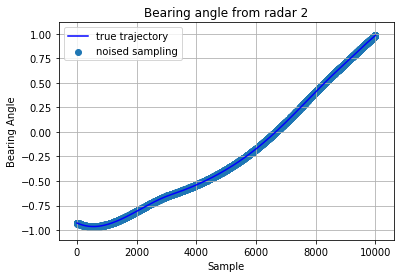

In [14]:
plt.plot(radar_bearing1[:,1],'b-')
#plt.plot(radar_bearing1[:,1],radar_bearing1[:,2],'g-')
plt.scatter(x=np.arange(radar_bearing1.shape[0]),y=noisy_radar_bearing1[:,1])
plt.grid(True)
plt.title('Bearing angle from radar 2')
plt.xlabel('Sample')
plt.ylabel('Bearing Angle')
plt.legend(['true trajectory', 'noised sampling'])
plt.show()

In [15]:
##invert the noisy measurements to get the radar estimated position

In [16]:
##create an inverse function for this
def invert_bearings(radar, angle1, angle2):
    a_p = np.tan(angle1)
    b_p = np.tan(angle2)
    
    x1 = radar[0,0]
    x2 = radar[1,0]
    y1 = radar[0,1]
    y2 = radar[1,1]
    
    xk = ((a_p*x1)-(b_p*x2)+y2-y1)/(a_p-b_p)
    yk = b_p*(xk-x2)+y2
    
    sol_vec = np.array([[-1*a_p*(radar[0,0])+radar[0,1]], [-1*b_p*(radar[1,0])+radar[1,1]]])
    A_mat = np.array([[1, -1*a_p], [1, -1*b_p]])
    x_vec = np.matmul(np.linalg.inv(A_mat),sol_vec)
    
    return yk, xk;

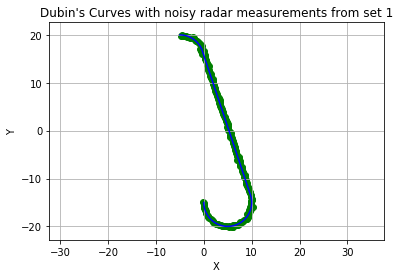

In [17]:
noised_path1 = np.zeros(path.shape)

for i in range(0, noised_path1.shape[0]):
     yk, xk = invert_bearings(radar_set1, noisy_radar_bearing1[i,0], noisy_radar_bearing1[i,1])
     noised_path1[i,1] = yk
     noised_path1[i,0] = xk

noised_path_sam1 = np.zeros(noise_path_intg.shape)
for i in range(0,200):
    noised_path_sam1[i,:] = noised_path1[50*i,:]    
    
#noised_path1 = clear_outliers(noised_path1)    
plt.plot(path[:,0],path[:,1],'b-') 
plt.scatter(noised_path_sam1[:,0],noised_path_sam1[:,1],color='g')
plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves with noisy radar measurements from set 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

[[-100.  -10.]
 [-100.    5.]]


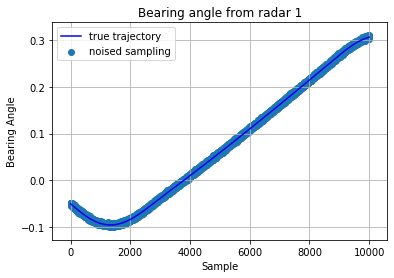

In [18]:
##generate the "true" bearing angle for the second radar set
radar_set2 = np.array([[-100, -10],[-100,5]], dtype=float)
print(radar_set2)
radar_bearing2 = np.zeros(path.shape)
radar_bearing2[:,2] = path[:,2]



for i in range(0,radar_bearing2.shape[0]):
    
    radar_bearing2[i,0] = np.arctan2((path[i,1]-radar_set2[0,1]),(path[i,0]-radar_set2[0,0]))
    radar_bearing2[i,1] = np.arctan2((path[i,1]-radar_set2[1,1]),(path[i,0]-radar_set2[1,0]))


noisy_radar_bearing2 = np.zeros(path.shape)   
for i in range(0,radar_bearing1.shape[0]):
    
    noisy_radar_bearing2[i,0] = radar_bearing2[i,0]+noise_sam(0,deg2rad(0.1))
    noisy_radar_bearing2[i,1] = radar_bearing2[i,1]+noise_sam(0,deg2rad(0.1))
    noisy_radar_bearing2[i,2] = radar_bearing2[i,2]+noise_sam(0,deg2rad(np.sqrt(0.1)))
    
plt.plot(radar_bearing2[:,0],'b-')
#plt.plot(radar_bearing1[:,1],radar_bearing1[:,2],'g-')
plt.scatter(x=np.arange(radar_bearing2.shape[0]),y=noisy_radar_bearing2[:,0])
plt.grid(True)
plt.title('Bearing angle from radar 1')
plt.xlabel('Sample')
plt.ylabel('Bearing Angle')
plt.legend(['true trajectory', 'noised sampling'])
plt.show()


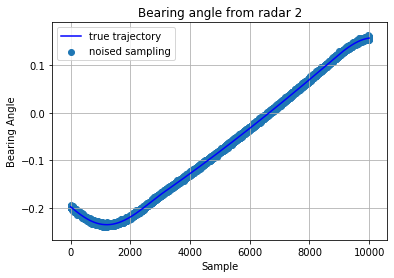

In [19]:
plt.plot(radar_bearing2[:,1],'b-')
#plt.plot(radar_bearing2[:,1],radar_bearing2[:,2],'g-')
plt.scatter(x=np.arange(radar_bearing2.shape[0]),y=noisy_radar_bearing2[:,1])
plt.grid(True)
plt.title('Bearing angle from radar 2')
plt.xlabel('Sample')
plt.ylabel('Bearing Angle')
plt.legend(['true trajectory', 'noised sampling'])
plt.show()

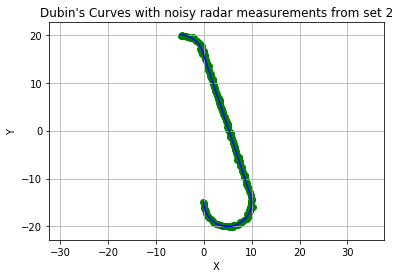

In [20]:
noised_path2 = np.zeros(path.shape)

for i in range(0, noised_path2.shape[0]):
     yk, xk = invert_bearings(radar_set2, noisy_radar_bearing2[i,0], noisy_radar_bearing2[i,1])
     noised_path2[i,1] = yk
     noised_path2[i,0] = xk

noised_path_sam2 = np.zeros(noise_path_intg.shape)
for i in range(0,200):
    noised_path_sam2[i,:] = noised_path1[50*i,:]    
    
#noised_path1 = clear_outliers(noised_path1)    
plt.plot(path[:,0],path[:,1],'b-') 
plt.scatter(noised_path_sam1[:,0],noised_path_sam2[:,1],color='g')
plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves with noisy radar measurements from set 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()